In [40]:
import geopandas as gpd
import pandas as pd
import rioxarray as rxr
import os
from scipy.stats import mode
import numpy as np
import rasterio
import matplotlib.pyplot as plt

In [ ]:
IDir = r'/Volumes/PhD/imagery/masters/output/dNBR/'

basin_path = r'/Volumes/PhD/imagery/masters/ROC/ROC_basins.shp'
basins = gpd.read_file(basin_path)
basin_id = basins['BASIN_ID']
basin_RI = basins['RI']
basin_ROC = basins['Field']
basin_data = {
    'BASIN_ID': basin_id,
    'RI': basin_RI,
    'ROC': basin_ROC
}
basin_df = pd.DataFrame(basin_data)
basin_df

,BASIN_ID,RI,ROC
0,17499,5.08,1
1,3115,7.11,4
2,3589,7.11,4
3,5683,12.95,4
4,5920,6.10,4
...,...,...,...
732,15065,9.14,0
733,35852,7.37,0
734,36553,7.37,0
735,36955,7.37,0


In [ ]:
def M1(dnbr, basin_data,
          save=False):
    
    # Coefficients for Southern California
    b = -3.63
    b_1 = 0.41
    b_2 = 0.67
    b_3 = 0.7
    

    results = []

    for basin_id, basin_row in basin_data.iterrrows():
        # File naming
        dnbr_flat = dnbr.values.flatten()
        pixarr = np.empty((dnbr_flat.shape[0]), dtype= float)
        pixarr[:] = np.nan
        x = np.where(np.isnan(dnbr_flat) == False)
            
        # Getting the data from dnbr_flat
        dnbrdata = dnbr_flat[x]
        dnbrdata = np.mean(dnbrdata)
            
        # Pulling tif metadata
        metadata = dnbr.attrs
        x_1 = float(metadata.get('X1'))
        x_3 = float(metadata.get('X3'))
        
        R = basin_row['RI']

        lnx =  b + (b_1 * x_1 * R) + (b_2 * dnbrdata * R) + (b_3 * x_3 * R)
        prob = (e ** lnx) / (1.0 + e ** lnx)
        results.append({'BASIN_ID': basin_id, 'Probability': prob})
    results_df = pd.DataFrame(results)
    return results_df

In [ ]:
file_list = os.listdir(IDir)
basin_ids = set(basin_df["BASIN_ID"].astype(str))  # Ensure IDs are strings

# Filter files by matching the Basin_ID in the filename
matching_files = [file for file in file_list if any(f"basin_{basin_id}" in file for basin_id in basin_ids)]

# Print matching files or process them
print(f"Found {len(matching_files)} matching files:")
for file in matching_files:
    image = rxr.open_rasterio(file)
    
    dnbr_flat = dnbr.values.flatten()
    pixarr = np.empty((dnbr_flat.shape[0]), dtype= float)
    pixarr[:] = np.nan
    x = np.where(np.isnan(dnbr_flat) == False)
    

Found 745 matching files:
basin_10048_dNBR.tif
basin_10058_dNBR.tif
basin_10060_dNBR.tif
basin_10104_dNBR.tif
basin_10155_dNBR.tif
basin_10194_dNBR.tif
basin_10225_dNBR.tif
basin_10397_dNBR.tif
basin_10416_dNBR.tif
basin_10420_dNBR.tif
basin_10421_dNBR.tif
basin_10430_dNBR.tif
basin_10505_dNBR.tif
basin_10584_dNBR.tif
basin_10657_dNBR.tif
basin_10701_dNBR.tif
basin_10718_dNBR.tif
basin_10720_dNBR.tif
basin_10746_dNBR.tif
basin_10797_dNBR.tif
basin_10807_dNBR.tif
basin_10808_dNBR.tif
basin_10810_dNBR.tif
basin_10814_dNBR.tif
basin_10865_dNBR.tif
basin_10890_dNBR.tif
basin_10936_dNBR.tif
basin_11092_dNBR.tif
basin_11112_dNBR.tif
basin_11123_dNBR.tif
basin_11171_dNBR.tif
basin_11202_dNBR.tif
basin_11209_dNBR.tif
basin_11240_dNBR.tif
basin_11270_dNBR.tif
basin_11273_dNBR.tif
basin_11326_dNBR.tif
basin_11335_dNBR.tif
basin_11375_dNBR.tif
basin_11441_dNBR.tif
basin_11460_dNBR.tif
basin_11469_dNBR.tif
basin_11514_dNBR.tif
basin_11522_dNBR.tif
basin_11537_dNBR.tif
basin_11539_dNBR.tif
basin_11

In [35]:
def calculate_image_statistics(dnbr_dir, basin_data):
    # Ensure BASIN_ID is string to match filenames
    basin_data["BASIN_ID"] = basin_data["BASIN_ID"].astype(str)

    # Get a list of all files in the directory
    file_list = os.listdir(dnbr_dir)

    # Initialize lists to store the computed statistics
    mean_list = []
    median_list = []
    peak_frequency_list = []

    # Loop through each row in basin_data
    for index, row in basin_data.iterrows():
        basin_id = row["BASIN_ID"]

        # Construct the expected file name
        file_name = f"basin_{basin_id}_dNBR.tif"

        # Check if the file exists
        if file_name not in file_list:
            print(f"No matching file for Basin_ID: {basin_id}")
            mean_list.append(np.nan)
            median_list.append(np.nan)
            peak_frequency_list.append(np.nan)
            continue

        # Full path to the matching file
        file_path = os.path.join(dnbr_dir, file_name)

        try:
            # Open the raster file
            with rasterio.open(file_path) as src:
                dnbr_data = src.read(1)  # Read the first band
                dnbr_data = dnbr_data.astype(float)  # Ensure it's float for calculations
                
                # Replace nodata values with NaN
                dnbr_data[dnbr_data == src.nodata] = np.nan

                # Calculate statistics
                mean_value = np.nanmean(dnbr_data)
                median_value = np.nanmedian(dnbr_data)
                
                # Calculate peak frequency
                values, counts = np.unique(dnbr_data[~np.isnan(dnbr_data)], return_counts=True)
                peak_frequency = values[np.argmax(counts)] if len(values) > 0 else np.nan

                # Append statistics to lists
                mean_list.append(mean_value)
                median_list.append(median_value)
                peak_frequency_list.append(peak_frequency)

        except Exception as e:
            print(f"Error processing Basin_ID {basin_id}: {e}")
            mean_list.append(np.nan)
            median_list.append(np.nan)
            peak_frequency_list.append(np.nan)

    # Add the calculated statistics to basin_data
    basin_data["Mean_dNBR"] = mean_list
    basin_data["Median_dNBR"] = median_list
    basin_data["PeakFrequency_dNBR"] = peak_frequency_list

    return basin_data

In [38]:
x = calculate_image_statistics(IDir, basin_df)
print(x)

    BASIN_ID     RI  ROC  Mean_dNBR  Median_dNBR  PeakFrequency_dNBR
0      17499   5.08    1   0.471854     0.477169           -0.059227
1       3115   7.11    4   0.072363     0.014718           -0.116260
2       3589   7.11    4   0.216498     0.051373           -0.179117
3       5683  12.95    4   0.692429     0.702799            0.194119
4       5920   6.10    4   0.605956     0.651802            0.192814
..       ...    ...  ...        ...          ...                 ...
732    15065   9.14    0   0.164376     0.111513           -0.125809
733    35852   7.37    0   0.284851     0.279801            0.126488
734    36553   7.37    0   0.348485     0.339397            0.179230
735    36955   7.37    0   0.208930     0.202108           -0.020815
736    37056   7.37    0   0.226340     0.245195           -0.212849

[737 rows x 6 columns]


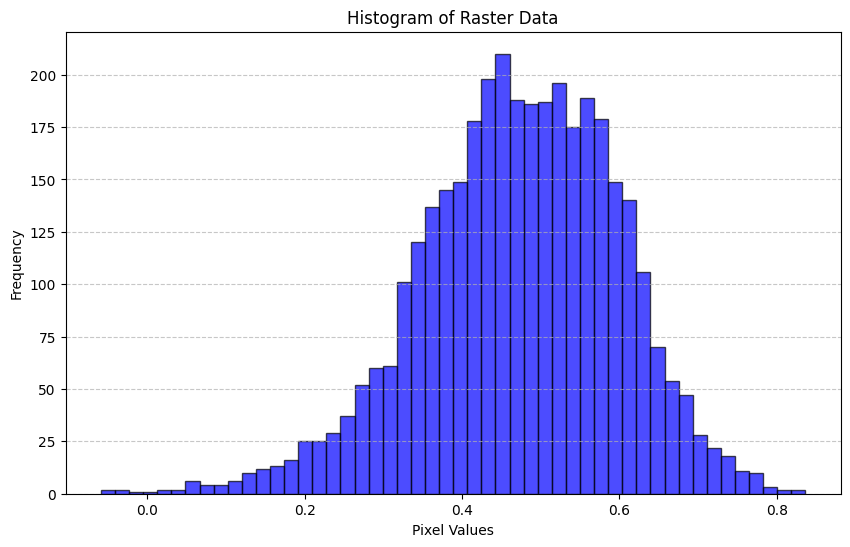

In [42]:
dnbr_c = r'/Volumes/PhD/imagery/masters/output/dNBR/basin_17499_dNBR.tif'
dnbr_c = rxr.open_rasterio(dnbr_c)
dnbr_array = dnbr_c.values

# Flatten the array and remove NaN values
valid_data = dnbr_array.flatten()
valid_data = valid_data[~np.isnan(valid_data)]

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(valid_data, bins=50, color='blue', alpha=0.7, edgecolor='black')  # Adjust bins as needed
plt.title("Histogram of Raster Data")
plt.xlabel("Pixel Values")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()